# QC Analysis of CTD Oxygen Data 
- from CTD Bottle samples and Winkler Titrations 
- Seabird Documentation [weblink](http://www.seabird.com/document/an64-2-sbe-43-dissolved-oxygen-sensor-calibration-and-data-corrections)

## Data Sources
- Seabird .btl files
- Oxy titration values from C.Mordy / E.Weisgarver
- Field notes and metadata

### Before importing here you must
- build the excel file

(currently these are all combined in an excel file - **TODO**: work from the orignal files)

#### Current Active Cruise - DY1708

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np

In [12]:
source_file = '/Users/bell/ecoraid/2017/CTDcasts/os1701l1/working/DiscreteOxygen/OS1701L1-L3_OxygenCal.xlsx'

In [17]:
dateparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_excel(source_file,sheet_name='Comparison_python',date_parse='date_time',index_col='date_time')


In [19]:
try:
    df.dropna(subset=['cast','O2, uM/kg00','O2, uM/kg01','Sbeox0Mm/Kg','Sbeox1Mm/Kg'],inplace=True)
except:
    df.dropna(subset=['cast','O2, uM/kg00','O2, uM/kg01','Sbox0Mm/Kg','Sbox1Mm/Kg'],inplace=True)
df.describe()

,nb,Sal00,Sbox0Mm/Kg,Sbox1Mm/Kg,Sigma-t00,Density11,Sal11,Sbeox0PS,Sbeox1PS,T090C,T190C,Scan,PrDM,FlECO-AFL,TurbWETntu0,Cast / Bottle ID,Niskin / Time,O2 (uM/l),"O2, uM/kg00","O2, uM/kg01"
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,3.702381,31.785577,269.466905,266.525869,25.087019,1025.242882,31.785980,85.819345,84.884548,5.085320,5.085370,8138.523810,33.160583,1.176012,0.903596,63.833333,3.702381,295.447735,288.223170,288.223046
std,2.806102,1.166054,31.282969,31.057319,1.029552,1.239743,1.167825,11.204706,11.132874,2.386700,2.387009,6443.676666,64.955111,1.092462,0.899464,48.014765,2.806102,33.559299,32.885022,32.884863
min,1.000000,25.572700,185.831000,183.116000,20.294700,1020.308500,25.575800,58.553000,57.698000,-0.567000,-0.566400,2417.000000,0.635000,-1.001000,-0.380000,1.000000,1.000000,203.634001,198.532682,198.532967
25%,1.000000,31.328325,254.870000,250.931250,24.524400,1024.542850,31.331050,78.832000,78.177250,3.693425,3.700150,3506.000000,1.248000,0.427775,0.226250,10.500000,1.000000,277.561738,270.555534,270.555598
50%,4.000000,32.021250,273.558000,273.672500,25.120550,1025.144000,32.022000,88.955500,88.052500,5.268050,5.268000,6413.000000,21.622000,0.772100,0.497950,67.000000,4.000000,301.115689,293.847124,293.847546
75%,5.000000,32.434675,290.863000,287.012500,25.810600,1025.988200,32.437675,94.836000,93.834000,6.692725,6.692275,10444.500000,40.334000,1.501200,1.286750,110.750000,5.000000,319.888521,311.875278,311.874473
max,11.000000,34.848400,320.578000,318.380000,27.950700,1030.300300,34.847600,103.750000,103.272000,10.038800,10.039100,43478.000000,497.645000,4.474800,3.702700,135.000000,11.000000,346.738201,339.840379,339.841214


In [27]:
#multiple acceptable column names for oxygen so rename if Sbox is found
if 'Sbox0Mm/Kg' in list(df.columns):
    df['Sbeox0Mm/Kg'] = df['Sbox0Mm/Kg']
if 'Sbox1Mm/Kg' in list(df.columns):
    df['Sbeox1Mm/Kg'] = df['Sbox1Mm/Kg']


## Field Calibration Methods

### Bulk slope offset

Seabird suggests not to evaluate the offset but to evaluate the slope as the drift is in the slope.  See below for Seabird Method.
FOCI has historically calculated the bulk offset correction (while not forcing through zero... which we probably should).  The bulk method treats low and high concentrations equally, but this is not necessarily the case and SBE suggests not doing an offset for values less than **???** 

### Bulk Offset: Bottle-Winkler(Flask) Oxygen
(offset below is SBE Bottle Value - Flask)

Text(0.5,0,'Temperature')

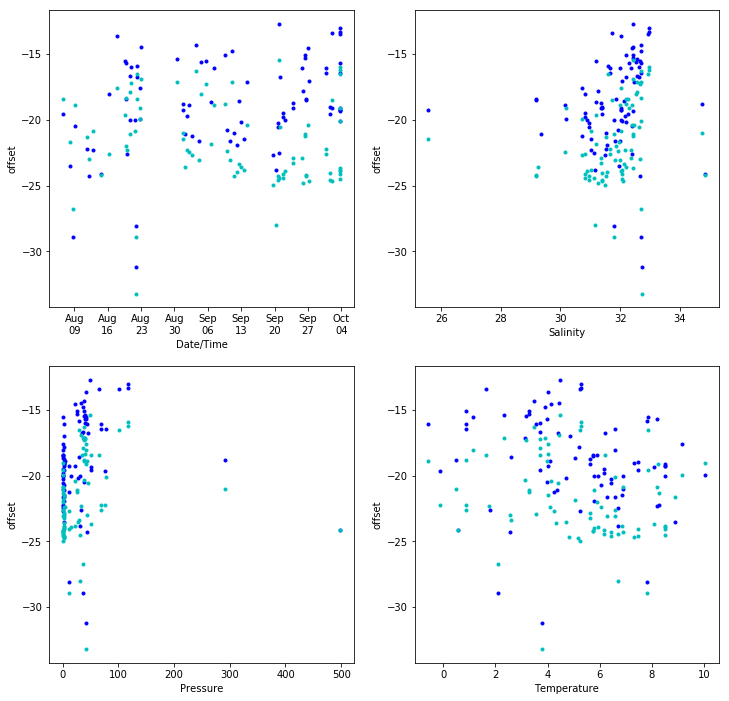

In [28]:
#Plot Basic Offset for Evaluation
fig, ax = plt.subplots(2,2,'none',figsize=(12, 12))
plt.subplot(221)
plt.plot(df.index,(df['Sbeox0Mm/Kg']-df['O2, uM/kg00']),'b.')
plt.plot(df.index,(df['Sbeox1Mm/Kg']-df['O2, uM/kg01']),'c.')
ax = plt.gca()
xfmt = mdates.DateFormatter('%b\n%d')
ax.xaxis.set_major_formatter(xfmt)
plt.ylabel('offset')
plt.xlabel('Date/Time')

plt.subplot(222)
plt.plot(df['Sal00'],(df['Sbeox0Mm/Kg']-df['O2, uM/kg00']),'b.')
plt.plot(df['Sal11'],(df['Sbeox1Mm/Kg']-df['O2, uM/kg01']),'c.')
plt.ylabel('offset')
plt.xlabel('Salinity')

plt.subplot(223)
plt.plot(df['PrDM'],(df['Sbeox0Mm/Kg']-df['O2, uM/kg00']),'b.')
plt.plot(df['PrDM'],(df['Sbeox1Mm/Kg']-df['O2, uM/kg01']),'c.')
plt.ylabel('offset')
plt.xlabel('Pressure')

plt.subplot(224)
plt.plot(df['T090C'],(df['Sbeox0Mm/Kg']-df['O2, uM/kg00']),'b.')
plt.plot(df['T190C'],(df['Sbeox1Mm/Kg']-df['O2, uM/kg01']),'c.')
plt.ylabel('offset')
plt.xlabel('Temperature')


In [29]:
z1 = np.polyfit(x=df['Sbeox0Mm/Kg'].values, y=df['O2, uM/kg00'].values, deg=1)
z2 = np.polyfit(x=df['Sbeox1Mm/Kg'].values, y=df['O2, uM/kg01'].values, deg=1)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)
df['trendline1'] = p1(df['Sbeox0Mm/Kg'].values)
df['trendline2'] = p2(df['Sbeox1Mm/Kg'].values)

Text(0.5,0,'SBE CTD Oxygens uM/kg')

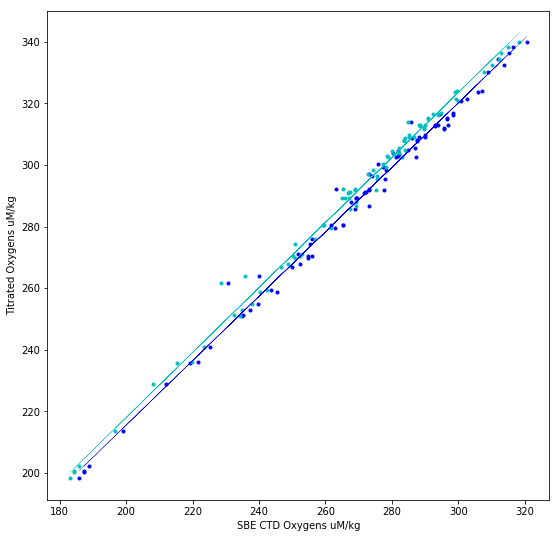

In [30]:
fig, ax = plt.subplots(figsize=(9, 9))
plt.plot(df['Sbeox0Mm/Kg'],df['O2, uM/kg00'],'b.')
plt.plot(df['Sbeox1Mm/Kg'],df['O2, uM/kg01'],'c.')
plt.plot(df['Sbeox0Mm/Kg'],df['trendline1'],'b--',linewidth=0.25)
plt.plot(df['Sbeox1Mm/Kg'],df['trendline2'],'c--',linewidth=0.25)
plt.ylabel('Titrated Oxygens uM/kg')
plt.xlabel('SBE CTD Oxygens uM/kg')

In [31]:
print('Primary: y={0:.3f} x + {1:.2f}'.format(z1[0],z1[1]))
print('Secondary: y={0:.3f} x + {1:.2f}'.format(z2[0],z2[1]))

Primary: y=1.046 x + 6.30
Secondary: y=1.055 x + 6.99


#### Correct for linear fit

In [32]:
df['Primary'] = 1.047 * df['Sbeox0Mm/Kg'] 
df['Secondary'] = 1.049 * df['Sbeox1Mm/Kg']

Text(0.5,0,'Temperature')

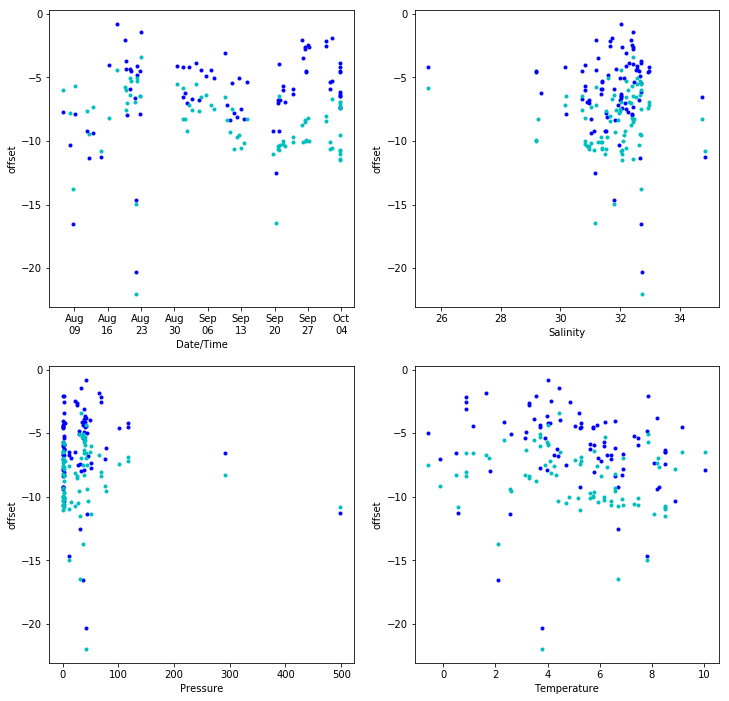

In [33]:
fig, ax = plt.subplots(2,2,'none',figsize=(12, 12))
plt.subplot(221)
plt.plot(df.index,(df['Primary']-df['O2, uM/kg00']),'b.')
plt.plot(df.index,(df['Secondary']-df['O2, uM/kg01']),'c.')
ax = plt.gca()
xfmt = mdates.DateFormatter('%b\n%d')
ax.xaxis.set_major_formatter(xfmt)
plt.ylabel('offset')
plt.xlabel('Date/Time')

plt.subplot(222)
plt.plot(df['Sal00'],(df['Primary']-df['O2, uM/kg00']),'b.')
plt.plot(df['Sal11'],(df['Secondary']-df['O2, uM/kg01']),'c.')
plt.ylabel('offset')
plt.xlabel('Salinity')

plt.subplot(223)
plt.plot(df['PrDM'],(df['Primary']-df['O2, uM/kg00']),'b.')
plt.plot(df['PrDM'],(df['Secondary']-df['O2, uM/kg01']),'c.')
plt.ylabel('offset')
plt.xlabel('Pressure')

plt.subplot(224)
plt.plot(df['T090C'],(df['Primary']-df['O2, uM/kg00']),'b.')
plt.plot(df['T190C'],(df['Secondary']-df['O2, uM/kg01']),'c.')
plt.ylabel('offset')
plt.xlabel('Temperature')


### Alternatively, Fit through zero

/Users/bell/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/bell/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0.5,0,'SBE CTD Oxygens uM/kg')

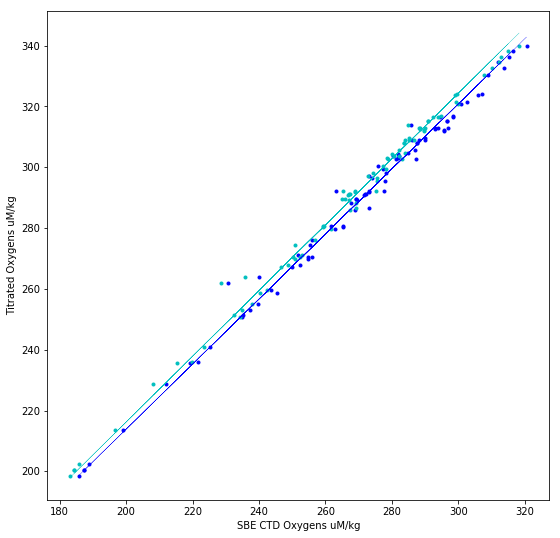

In [34]:
x1=df['Sbeox0Mm/Kg'].values
x1=x1[:,np.newaxis]

x2=df['Sbeox1Mm/Kg'].values
x2=x2[:,np.newaxis]

z1 = np.linalg.lstsq(x1, df['O2, uM/kg00'].values)
z2 = np.linalg.lstsq(x2, df['O2, uM/kg01'].values)

df['trendline1'] = z1[0]*(x1)
df['trendline2'] = z2[0]*(x2)

fig, ax = plt.subplots(figsize=(9, 9))
plt.plot(df['Sbeox0Mm/Kg'],df['O2, uM/kg00'],'b.')
plt.plot(df['Sbeox1Mm/Kg'],df['O2, uM/kg01'],'c.')
plt.plot(df['Sbeox0Mm/Kg'],df['trendline1'],'b--',linewidth=0.25)
plt.plot(df['Sbeox1Mm/Kg'],df['trendline2'],'c--',linewidth=0.25)
plt.ylabel('Titrated Oxygens uM/kg')
plt.xlabel('SBE CTD Oxygens uM/kg')

In [35]:
print('Primary: y={0:.3f} x '.format(z1[0][0]))
print('Secondary: y={0:.3f} x '.format(z2[0][0]))

Primary: y=1.069 x 
Secondary: y=1.081 x 


**TODO:** Validate Seabird suggested methodology with our original methodology and generate a report like this one for every cruise from hereon

### SBE Offset Slope Correction Method

Found in [Application Note 64-2](https://www.seabird.com/asset-get.download.jsa?code=251034) (2012)

Calculate the ratio between the the Winkler Value and SBE43 Bottle Value (Winkler/SBE43)  (making sure units are concistent).  This is the slope correction value which can be applied over the cruise in varying ways.

Method 1: Take average of all corrections and apply a bulk correction (this should be similar to the forced zero offset above)
Method 2: Apply linear fit to all corrections over time (for time dependent corrections - eg fouling over time)
Method 3: Apply correction on each cast based on winkler for each cast

Limitations exist for values 2-3ml/L or lower, a Winkler sample may have large variablility (hard to get a good one), correction factors greater than 1.2 may indicate that the sensor needs to be calibrated

Text(0.5,0,'Date/Time')

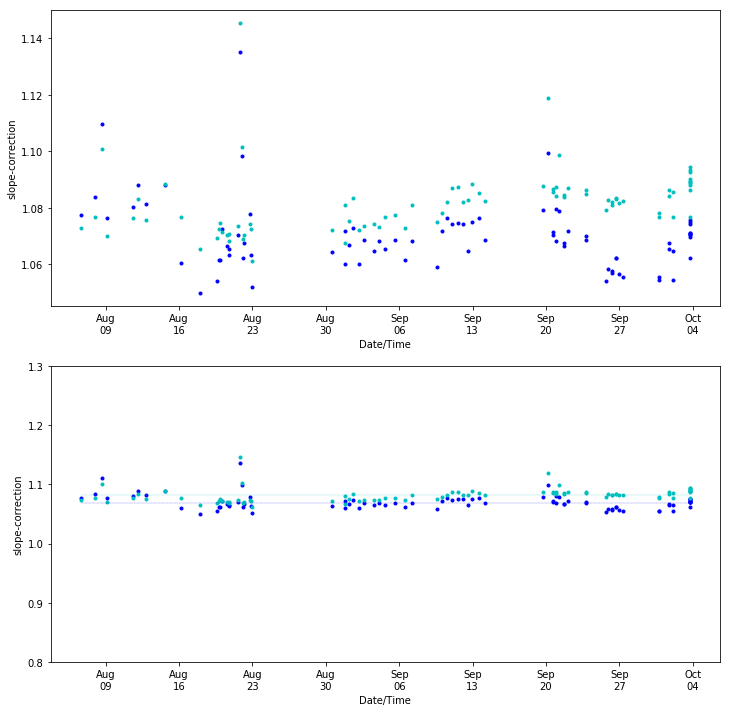

In [36]:
#Plot Basic Ratio for Evaluation
fig, ax = plt.subplots(2,1,'none',figsize=(12, 12))
plt.subplot(211)
plt.plot(df.index,(df['O2, uM/kg00']/df['Sbeox0Mm/Kg']),'b.')
plt.plot(df.index,(df['O2, uM/kg01']/df['Sbeox1Mm/Kg']),'c.')
ax = plt.gca()
xfmt = mdates.DateFormatter('%b\n%d')
ax.xaxis.set_major_formatter(xfmt)
plt.ylabel('slope-correction')
plt.xlabel('Date/Time')

plt.subplot(212)
plt.plot(df.index,(df['O2, uM/kg00']/df['Sbeox0Mm/Kg']),'b.')
plt.plot(df.index,(df['O2, uM/kg01']/df['Sbeox1Mm/Kg']),'c.')
plt.plot(df.index,np.ones(len(df))*(df['O2, uM/kg00']/df['Sbeox0Mm/Kg']).median(),'b--',linewidth=0.25)
plt.plot(df.index,np.ones(len(df))*(df['O2, uM/kg01']/df['Sbeox1Mm/Kg']).median(),'c--',linewidth=0.25)
ax = plt.gca()
ax.set_ylim([.8,1.3])
xfmt = mdates.DateFormatter('%b\n%d')
ax.xaxis.set_major_formatter(xfmt)
plt.ylabel('slope-correction')
plt.xlabel('Date/Time')


In [37]:
print('Primary Corr Ratio:   median:{0:.3f} mean:{1:.3f} '.format((df['O2, uM/kg00']/df['Sbeox0Mm/Kg']).median(), (df['O2, uM/kg00']/df['Sbeox0Mm/Kg']).mean()))
print('Secondary Corr Ratio: median:{0:.3f} mean:{1:.3f} '.format((df['O2, uM/kg01']/df['Sbeox1Mm/Kg']).median(), (df['O2, uM/kg01']/df['Sbeox1Mm/Kg']).mean()))

Primary Corr Ratio:   median:1.069 mean:1.070 
Secondary Corr Ratio: median:1.082 mean:1.082 


In [42]:
# or for chosen subperiod and values greater than 500
sub_time=['2017-08-15','2017-11-15']
df_sub = df[df.PrDM < 500]
print('Primary Corr Ratio:   median:{0:.3f} mean:{1:.3f} '.format(
    (df_sub['O2, uM/kg00'][sub_time[0]:sub_time[1]]/df_sub['Sbeox0Mm/Kg'][sub_time[0]:sub_time[1]]).median(), 
    (df_sub['O2, uM/kg00'][sub_time[0]:sub_time[1]]/df_sub['Sbeox0Mm/Kg'][sub_time[0]:sub_time[1]]).mean()))
print('Secondary Corr Ratio: median:{0:.3f} mean:{1:.3f} '.format(
    (df_sub['O2, uM/kg01'][sub_time[0]:sub_time[1]]/df_sub['Sbeox1Mm/Kg'][sub_time[0]:sub_time[1]]).median(), 
    (df_sub['O2, uM/kg01'][sub_time[0]:sub_time[1]]/df_sub['Sbeox1Mm/Kg'][sub_time[0]:sub_time[1]]).mean()))

Primary Corr Ratio:   median:1.068 mean:1.068 
Secondary Corr Ratio: median:1.082 mean:1.082 


### Apply Chosen SBE correction method

Using median ratio for bulk entire period

Text(0.5,0,'Temperature')

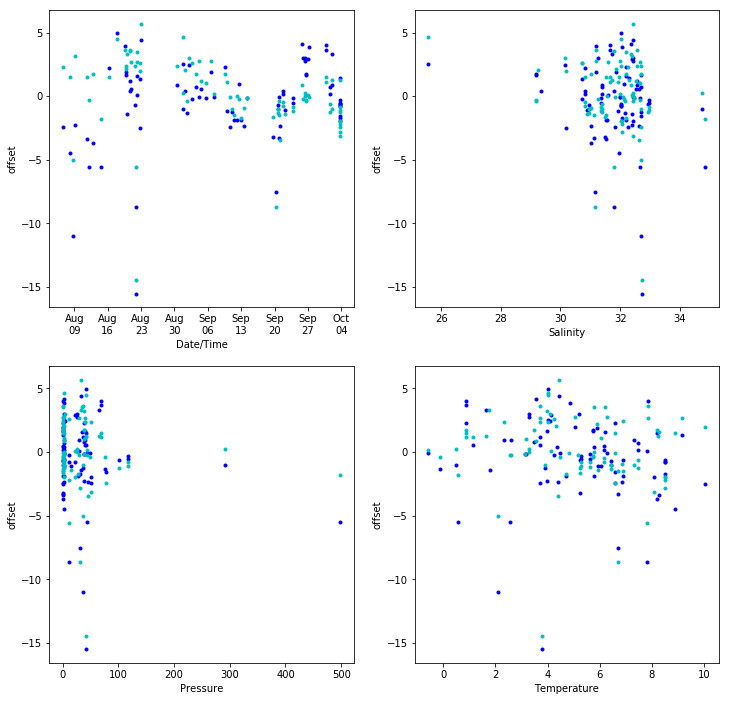

In [43]:
ratio_cor1 = 1.068
ratio_cor2 = 1.082

#Plot Offset Corrected Difference for Evaluation
fig, ax = plt.subplots(2,2,'none',figsize=(12, 12))
plt.subplot(221)
plt.plot(df.index,(df['Sbeox0Mm/Kg']*ratio_cor1-df['O2, uM/kg00']),'b.')
plt.plot(df.index,(df['Sbeox1Mm/Kg']*ratio_cor2-df['O2, uM/kg01']),'c.')
ax = plt.gca()
xfmt = mdates.DateFormatter('%b\n%d')
ax.xaxis.set_major_formatter(xfmt)
plt.ylabel('offset')
plt.xlabel('Date/Time')

plt.subplot(222)
plt.plot(df['Sal00'],(df['Sbeox0Mm/Kg']*ratio_cor1-df['O2, uM/kg00']),'b.')
plt.plot(df['Sal11'],(df['Sbeox1Mm/Kg']*ratio_cor2-df['O2, uM/kg01']),'c.')
plt.ylabel('offset')
plt.xlabel('Salinity')

plt.subplot(223)
plt.plot(df['PrDM'],(df['Sbeox0Mm/Kg']*ratio_cor1-df['O2, uM/kg00']),'b.')
plt.plot(df['PrDM'],(df['Sbeox1Mm/Kg']*ratio_cor2-df['O2, uM/kg01']),'c.')
plt.ylabel('offset')
plt.xlabel('Pressure')

plt.subplot(224)
plt.plot(df['T090C'],(df['Sbeox0Mm/Kg']*ratio_cor1-df['O2, uM/kg00']),'b.')
plt.plot(df['T190C'],(df['Sbeox1Mm/Kg']*ratio_cor2-df['O2, uM/kg01']),'c.')
plt.ylabel('offset')
plt.xlabel('Temperature')


### For deep casts or full profile bottle samples, slope correction should be a function of depth

Using median ratio for bulk entire period

In [ ]:
df[df['cast']=='ctd057']

In [ ]:
fig, ax = plt.subplots(1,1,'none',figsize=(6, 12))
plt.subplot(111)
plt.plot((df[df['cast']=='ctd057']['O2, uM/kg00']/df[df['cast']=='ctd057']['Sbeox0Mm/Kg']),df[df['cast']=='ctd057']['PrDM'],'b.')
plt.plot((df[df['cast']=='ctd057']['O2, uM/kg01']/df[df['cast']=='ctd057']['Sbeox1Mm/Kg']),df[df['cast']=='ctd057']['PrDM'],'c.')
ax = plt.gca()
plt.xlabel('slope-correction')
ax.invert_yaxis()
